# Replication for results in Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

In [ ]:
!pip install -U torch torchvision --index-url https://download.pytorch.org/whl/cu124

In [ ]:
!pip install transformers torch xformers==0.0.28.post3

In [ ]:
!pip uninstall pandas scikit-learn matplotlib torch seaborn transformers nltk vaderSentiment textstat

In [ ]:
!pip install -U pandas scikit-learn matplotlib torch seaborn transformers nltk vaderSentiment textstat

In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
import torch
from tqdm import tqdm
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, lr_scheduler
from transformers import BertTokenizer, BertForSequenceClassification, AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split

%matplotlib inline

## Download nltk files if necessary

In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')

## Loading the data

In [2]:
# df = pd.read_csv("data/labeled_data.csv", index_col=0)
df = pd.read_pickle("data/labeled_data.p")

In [3]:
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [4]:
df.describe()

,count,hate_speech,offensive_language,neither
count,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247
std,0.883060,0.631851,1.399459,1.113299
min,3.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000
50%,3.000000,0.000000,3.000000,0.000000
75%,3.000000,0.000000,3.000000,0.000000
max,9.000000,7.000000,9.000000,9.000000


In [5]:
df.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


In [6]:
# Load tokenizer and model
torch.cuda.empty_cache()

model_name = "GroNLP/hateBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(model_name, trust_remote_code=True, num_labels=3)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
model.to(device)
print(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


In [7]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            # 'token_type_ids': encoding['token_type_ids'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }


train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["tweet"].tolist(), df["class"].tolist(), test_size=0.2, stratify=df["class"]
)

train_dataset = HateSpeechDataset(train_texts, train_labels, tokenizer)
val_dataset = HateSpeechDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [8]:
def evaluate_model():
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    
    val_preds = []
    ground_truths = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
    
            outputs = model(
                input_ids, 
                attention_mask=attention_mask, 
            )
            preds = torch.argmax(outputs.logits, dim=1)
    
            val_preds.extend(preds.tolist())
            ground_truths.extend(labels.tolist())
    
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    print(f"Validation Accuracy: {correct / total:.4f}")
    report = classification_report( ground_truths, val_preds )
    return val_preds, ground_truths, report

In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_counts = np.bincount(train_labels)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class distribution:", class_counts)
print("Class weights:", class_weights)

Class distribution: [ 1144 15352  3330]
Class weights: tensor([5.7768, 0.4305, 1.9846], device='cuda:0')


In [10]:
def train_model(validate=False, epochs=3, weighted_loss=False):
    model.train()

    if weighted_loss:
        criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
    
            outputs = model(
                input_ids, 
                attention_mask=attention_mask, 
            )
            

            loss = criterion(outputs.logits, labels)
            
            total_loss += loss.item()
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")
        
        if validate:
            preds, labels, report = evaluate_model()
            print(report)

In [11]:
train_model(validate=True, epochs=2, weighted_loss=True)

100%|██████████| 620/620 [02:00<00:00,  5.16it/s]


Epoch 1, Loss: 0.5217


100%|██████████| 78/78 [00:10<00:00,  7.29it/s]


Validation Accuracy: 0.7872
              precision    recall  f1-score   support

           0       0.21      0.84      0.34       286
           1       0.98      0.76      0.86      3838
           2       0.87      0.88      0.88       833

    accuracy                           0.79      4957
   macro avg       0.69      0.83      0.69      4957
weighted avg       0.92      0.79      0.83      4957



100%|██████████| 620/620 [01:58<00:00,  5.22it/s]


Epoch 2, Loss: 0.3165


100%|██████████| 78/78 [00:10<00:00,  7.29it/s]

Validation Accuracy: 0.7880
              precision    recall  f1-score   support

           0       0.22      0.82      0.35       286
           1       0.98      0.75      0.85      3838
           2       0.83      0.95      0.88       833

    accuracy                           0.79      4957
   macro avg       0.68      0.84      0.69      4957
weighted avg       0.91      0.79      0.83      4957



100%|██████████| 78/78 [00:10<00:00,  7.41it/s]


Validation Accuracy: 0.7880


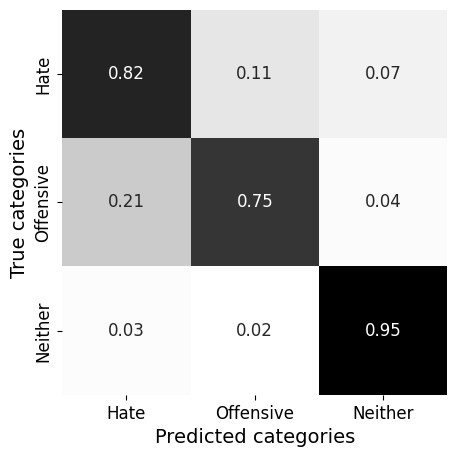

In [12]:
val_preds, ground_truths, report = evaluate_model()

plt.rc('pdf', fonttype=42)
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = False
# plt.rcParams['font.serif'] = 'Times'
# plt.rcParams['font.family'] = 'serif'
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix( ground_truths, val_preds )
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
# plt.ylabel(r'\textbf{True categories}',fontsize=14)
# plt.xlabel(r'\textbf{Predicted categories}',fontsize=14)
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

# Uncomment line below if you want to save the output
# plt.savefig('confusion.pdf')

In [ ]:
save_directory = "./bert_fine_tuned"

model.save_pretrained(save_directory)

torch.save({
    'model_state_dict': model.state_dict(),
    'config': model.config,
}, f"{save_directory}/pytorch_model_checkpoint.pt")

In [ ]:
save_directory = "./bert_fine_tuned"
model = BertForSequenceClassification.from_pretrained(save_directory)